In [36]:
#importing the necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import cv2
import imageio

import tensorflow as tf
from keras import layers
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Input, MaxPooling2D,GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import EfficientNetB0, VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [31]:
# Specify the path to your dataset
dataset_path = "dataset_raw/"

# Get a list of subdirectories (each subdirectory corresponds to a class)
class_folders = [f.name for f in os.scandir(dataset_path) if f.is_dir()]

# Get the number of classes
num_classes = len(class_folders)

# Print the number of classes
print("Number of classes:", num_classes)

Number of classes: 5


In [32]:
from keras.preprocessing.image import ImageDataGenerator #generates batches of data
img_size = 224
batch_size =128
fpath = "dataset_raw"
datagen = ImageDataGenerator(rescale=1/255.,
                             zoom_range=0.2,
                             validation_split = 0.2,
                             rotation_range=30,
                             horizontal_flip=True)

In [33]:
train = datagen.flow_from_directory(fpath,                      #train split
                                    target_size=(224,224),
                                    subset="training",
                                    class_mode='categorical',
                                    batch_size=batch_size)
valdata = datagen.flow_from_directory(fpath,                     #validation split
                                      target_size=(224,224),
                                      batch_size=64,
                                      subset='validation',
                                      class_mode='categorical')

Found 3474 images belonging to 5 classes.
Found 865 images belonging to 5 classes.


<Figure size 2000x2000 with 0 Axes>

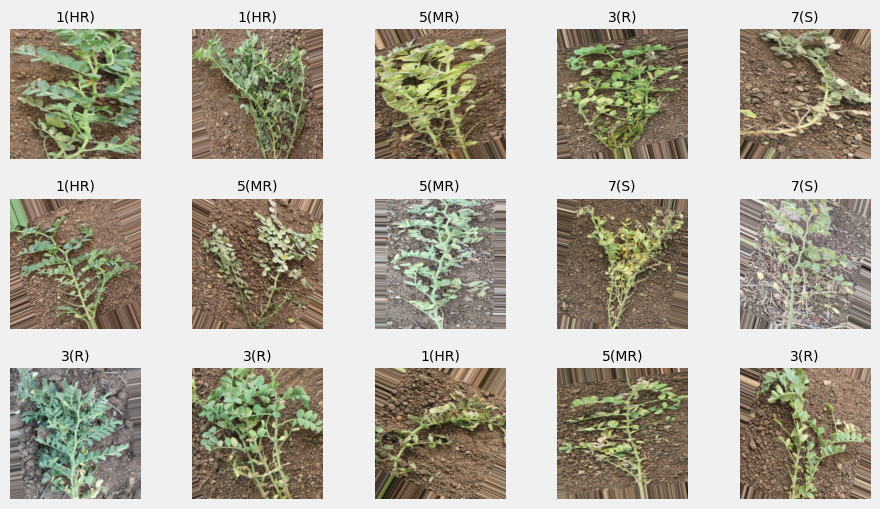

In [34]:
import numpy as np
import matplotlib.pyplot as plt
labels = [k for k in train.class_indices]
sample_generate = train.__next__()
images = sample_generate[0]
titles = sample_generate[1]
plt.figure(figsize = (20 , 20))
plt.figure(figsize=(10, 10))

for i in range(15):
    plt.subplot(5 , 5, i+1)
    plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
    plt.imshow(images[i])
    plt.title(labels[np.argmax(titles[i])].split('-')[-1], fontsize = 10)
    plt.axis("off")

### VGG16 model

In [35]:
img_size = 224 #in pixels
#VGG 16 model
base_model = tf.keras.applications.vgg16.VGG16(include_top = False,
                       weights = 'imagenet',
                       input_shape = (img_size,img_size,3))

In [11]:
for layer in base_model.layers[:-4]: #making unecessary layers untrainable
    layer.trainable = False

In [14]:
model = Sequential()      #creating model architecture
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(5, activation='softmax'))

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 14979909 (57.14 MB)
Trainable params: 7344645 (28.02 MB)
Non-trainable params: 7635264 (29.13 MB)
__________

In [15]:
model.compile(optimizer=Adam(learning_rate=0.0001), #model compilation
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [17]:
model_name = "model.h5"                           #saving model name
checkpoint = ModelCheckpoint(model_name,          #parameters to monitor in checkpoint
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=0.00000001) 
#dynamic learning for good results
#Reduce learning rate when a metric has stopped improving

In [18]:
#model fitting
history = model.fit(train,
                        epochs=10,
                        validation_data=valdata,
                        callbacks=[checkpoint, earlystopping, reduce_lr])
#epoch is set to 10, due to low computational power
#users can increase the no. of epochs to 40 for good accuracy
#save the model for future use

Epoch 1/10


28/28 [==============================] - ETA: 0s - loss: 1.4074 - accuracy: 0.3515 
Epoch 1: val_loss improved from inf to 1.21812, saving model to model.h5


D:\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 367s 13s/step - loss: 1.4074 - accuracy: 0.3515 - val_loss: 1.2181 - val_accuracy: 0.4439 - lr: 1.0000e-04
Epoch 2/10
28/28 [==============================] - ETA: 0s - loss: 1.0686 - accuracy: 0.5331
Epoch 2: val_loss improved from 1.21812 to 1.13708, saving model to model.h5
28/28 [==============================] - 354s 12s/step - loss: 1.0686 - accuracy: 0.5331 - val_loss: 1.1371 - val_accuracy: 0.4624 - lr: 1.0000e-04
Epoch 3/10
28/28 [==============================] - ETA: 0s - loss: 0.9371 - accuracy: 0.5964
Epoch 3: val_loss improved from 1.13708 to 1.11801, saving model to model.h5
28/28 [==============================] - 349s 12s/step - loss: 0.9371 - accuracy: 0.5964 - val_loss: 1.1180 - val_accuracy: 0.4798 - lr: 1.0000e-04
Epoch 4/10
28/28 [==============================] - ETA: 0s - loss: 0.8952 - accuracy: 0.6174
Epoch 4: val_loss improved from 1.11801 to 1.06011, saving model to model.h5
28/28 [==============================] - 34

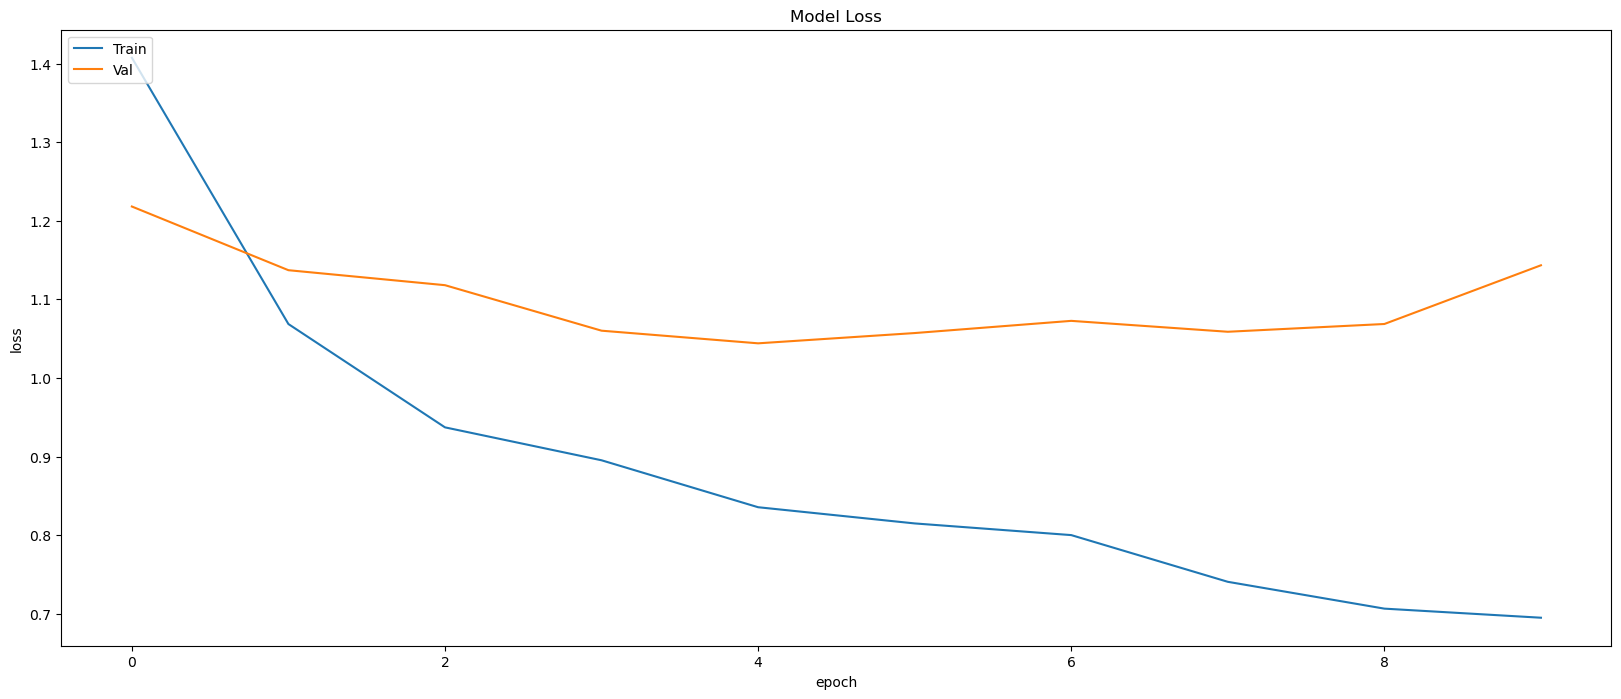

In [19]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
#plot the training loss over every epoch
plt.plot(history.history['val_loss'])
#plot the validation loss
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train','Val'],loc='upper left')
plt.show()

### MobileNet

In [20]:
#model compilation
model_mobile =tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=(224,224,3),
    weights='imagenet'
)
model_mobile.trainable = False
# adding input and output layers
input_layer = tf.keras.layers.Input(shape=(224,224,3))
x = model_mobile(input_layer,training=False)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024,activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
output = tf.keras.layers.Dense(5,activation='softmax')(x)

model_mobile = tf.keras.Model(inputs=[input_layer],outputs=[output])
model_mobile.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense_2 (Dense)             (None, 1024)              64226304  
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 5)                 5125      
                                                             

In [21]:
#setting early stopping and learning rate 
earlystop = EarlyStopping(patience=3)
reduce_learning_rate = ReduceLROnPlateau(monitor="val_accuracy",
                                         patience=2, verbose=1,
                                         factor=0.5,  min_lr=0.00001)

callbacks = [earlystop,reduce_learning_rate]
model_mobile.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [22]:
epochs2 = 1
history_mobile = model_mobile.fit(train,epochs=epochs2,validation_data=valdata,callbacks=callbacks)
#epoch is set to 1, due to low computational power
#users can increase the no. of epochs to 40 for good accuracy

28/28 [==============================] - 244s 9s/step - loss: 22.1320 - accuracy: 0.3687 - val_loss: 2.3314 - val_accuracy: 0.3931 - lr: 0.0010


### DenseNet Model

In [24]:
#model architecture
model_DenseNet =tf.keras.applications.DenseNet201(
    include_top=False,
    input_shape=(224,224,3),
    weights='imagenet'
)
model_DenseNet.trainable = False
#adding input and output layers
input_layer = tf.keras.layers.Input(shape=(224,224,3))
x = model_DenseNet(input_layer,training=False)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024,activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
output = tf.keras.layers.Dense(5,activation='softmax')(x)

model_DenseNet = tf.keras.Model(inputs=[input_layer],outputs=[output])
model_DenseNet.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 flatten_1 (Flatten)         (None, 94080)             0         
                                                                 
 dense_4 (Dense)             (None, 1024)              96338944  
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 5)                 5125      
                                                                 
Total params: 114666053 (437.42 MB)
Trainable params: 96344

In [25]:
#model compilation
model_DenseNet.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
#epoch is set to 1, due to low computational power
#users can increase the no. of epochs to 40 for good accuracy
history_dense = model_DenseNet.fit(train,epochs=epochs2,validation_data=valdata,callbacks=callbacks)

28/28 [==============================] - 436s 15s/step - loss: 32.3254 - accuracy: 0.3132 - val_loss: 4.0166 - val_accuracy: 0.3040 - lr: 0.0010


In [ ]:
# Run this cell for plots between training and validation accuracy
tr_acc = history_dense.history['accuracy']
tr_loss = history_dense.history['loss']
val_acc = history_dense.history['val_accuracy']
val_loss = history_dense.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}' 

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()